In [1]:
import warnings
warnings.filterwarnings("ignore")

# 分类

## MNIST

In [2]:
from sklearn.datasets import fetch_mldata
# from sklearn.datasets.base import get_data_home
# print(get_data_home())
mnist = fetch_mldata("MNIST original")
mnist

F:\Program_Files\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
F:\Program_Files\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


将特征向量还原为图片，像素为28*28

In [4]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[36000]

5.0

划分数据集，MNIST本身已经做好了划分  
同时将训练集顺序打乱

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二分类器

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

## 性能评估

### 使用交叉验证测量准确性

In [8]:
# 交叉验证是在训练集上完成的
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9449
0.9615
0.9513


使用sklearn本身的交叉验证函数

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9449, 0.9615, 0.9513])

定义一个对任何数据都预测为"非5"的分类器

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [11]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91075, 0.90935, 0.90885])

### 混淆矩阵

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52700,  1879],
       [  967,  4454]], dtype=int64)

### 准确率和召回率  
$precision = \frac{TP}{TP + FP}$  
$recall = \frac{TP}{TP + FN}$

In [14]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print(precision)
print(recall)

0.7033001736933523
0.821619627375023


$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$  
$= 2{\times}\frac{precision{\times}recall}{precision + recall}$  
$= \frac{TP}{TP + \frac{FN+FP}{2}}$

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7578696613918666

虽然F1值结合了precision和recall，但在某一具体任务中我们可能更关心其中一项指标。如：训练一个分类器检测视频是否适合儿童观看，我们会倾向于"即使拒绝了很多好视频，但能够保证留下来的视频都是好的的分类器(高准确率)"；训练分类器检测监控图像中的窃贼，"准确率为30%，召回率为99%的分类器"是合适的，虽然会得到一些错误的警报，但是能够保证几乎所有的窃贼都会被抓到。  
也可参考ISLR中文版p101.

### 准确率/召回率之间的折衷

对于SGD分类器提高阈值可以提高准确率，但是会降低召回率，因此准确率和召回率二者不可得兼

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold2 = 200000
y_some_digit_pred = (y_scores > threshold2)
print(y_some_digit_pred)

[217452.20650187]
[ True]
[ True]


计算SGD的决策函数分数，设置阈值和这个分数比较可以完成分类

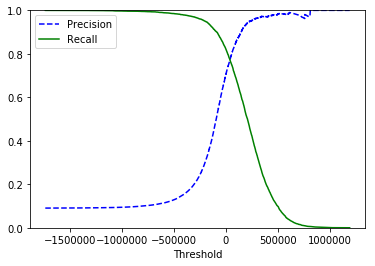

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [18]:
recalls[:-1].shape

(59776,)

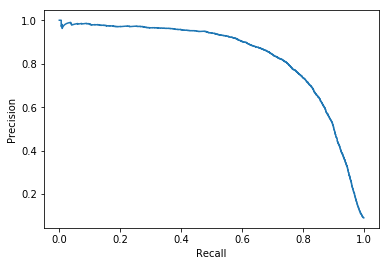

In [19]:
# plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### ROC曲线

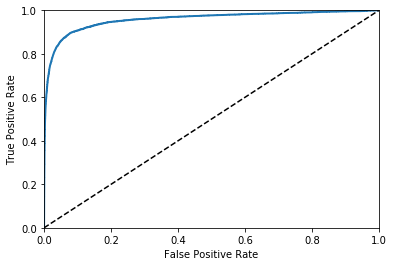

In [20]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9582057096375001

准确率/召回率曲线和ROC曲线的选择  
当positive class很少或者"相比于假阴性更关注假阳性时"，应选择前者，其他时候选择ROC曲线  
RandomForest没有decision_function，但可以计算属于某一类的概率

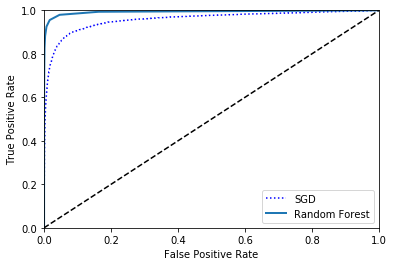

0.9931539151936594


In [22]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
y_probas = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method="predict_proba")
# y_probas包括了sample属于哪一类的概率，我们需要的是属于正例的概率，所以选择第二列
y_scores_rf = y_probas[:, 1]
fpr_rf, tpr_fr, threshold_rf = roc_curve(y_train_5, y_scores_rf)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_rf, tpr_fr, "Random Forest")
plt.legend(loc="bottom right")
plt.show()
print(roc_auc_score(y_train_5, y_scores_rf))

选择0.5作为阈值，计算RandomForest分类器的准确率和召回率

In [23]:
print(precision_score(y_train_5, y_scores_rf > 0.5))
print(recall_score(y_train_5, y_scores_rf > 0.5))

0.9852747252747253
0.8269691938756687


## 多类别分类 multiclass

One vs All/Rest  
One vs One  
SVM、线性分类器是严格的二分类器，只能通过OvA或OvO的策略才能进行多类别分类

In [24]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [25]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
sgd_clf.classes_[np.argmax(some_digit_scores)]

[[ -94496.38396406 -395142.69163963 -377538.38380903 -251156.61250384
  -308785.65845268   29096.05443864 -664589.85701827 -155259.11081438
  -520619.56400487 -640700.98794387]]


5.0

对SGD强制使用OvO策略

In [26]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5.]
45


使用RF做多类别分类

In [27]:
rf_clf.fit(X_train, y_train)
rf_clf.predict([some_digit])

array([5.])

In [28]:
rf_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

交叉验证，对输入做缩放后可提高预测准确度

In [29]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86682663, 0.86114306, 0.86042906])

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91256749, 0.90779539, 0.91038656])

## 误差分析

分析模型的误差类型

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5732,    3,   23,    9,   11,   45,   47,    9,   38,    6],
       [   2, 6479,   54,   18,    6,   41,    5,    9,  115,   13],
       [  49,   34, 5353,   89,   81,   23,   94,   51,  169,   15],
       [  45,   40,  146, 5311,    2,  255,   37,   49,  142,  104],
       [  17,   28,   36,    9, 5395,    8,   47,   37,   78,  187],
       [  66,   43,   39,  174,   73, 4609,  109,   26,  178,  104],
       [  32,   22,   52,    3,   40,   77, 5631,    8,   52,    1],
       [  24,   26,   78,   32,   56,   11,    5, 5775,   14,  244],
       [  52,  156,   79,  140,   17,  145,   55,   27, 5034,  146],
       [  43,   34,   22,   87,  168,   33,    3,  181,   82, 5296]],
      dtype=int64)

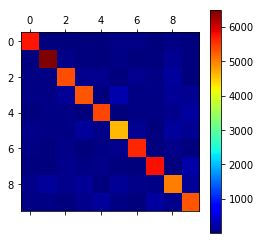

In [32]:
plt.matshow(conf_mx, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.show()

整体来看，分类效果很不错，因为混淆矩阵对角线很亮，而其他区域很暗。  
5/5分类效果不如其他数字好，颜色更靠近黄色，相应的1/1应该是最好的。  
有两种可能：1.数据集中5比较少 2.分类器对5表现不好

将对角线的值设为0，只看错误分类的情况

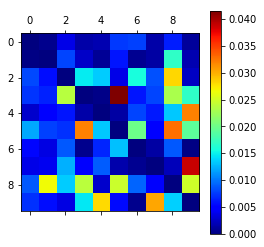

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.show()

行代表实际类别，列代表预测类别  
8、9两列很亮，说明许多数字被预测为8或9；8、9行也很亮，说明8、9也被误认为是其他数字  
3/5和5/3亮度也不相同，表明两个数字之间相互误判也不相同

上图提示我们应该要改善分类器在8和9上的表现，同时纠正3/5的混淆。  
可尝试：1.收集更多的数据 2.构造新特征

## 多标签分类 multilabel

In [34]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
# 按行连接两个矩阵，y_train_large是列向量
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [35]:
y_multilabel[:10]

array([[ True, False],
       [False, False],
       [False,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True]])

In [36]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
# print(f1_score(y_train, y_train_knn_pred, average="macro"))
# print(f1_score(y_train, y_train_knn_pred, average="weight"))

## 多输出分类 multioutput

In [38]:
# 可以写成 noise_train = np.random.randint(0, 100, X_train.shape)
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

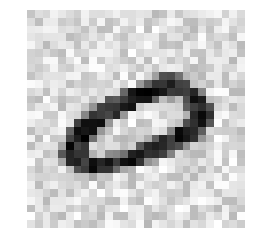

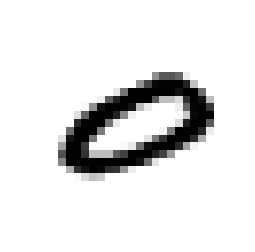

In [47]:
plt.imshow(X_train_mod[36000].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
plt.imshow(y_train_mod[36000].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()